### Question Pair Matching
Questions are composed of semantic, syntactic and grammatical features. The relative importance of different features will depend on the topic in which the question belongs. In order to leverage these properties to match question pairs, 3 models were combined with final boosted decision tree. The first model is a topic model. In order to model each questions topic, Latent Dirichlet Allocation (LDA) was used. A strict topic match between question 1 and question 2 was not enforced. Instead, predicted topics were passed to the final decision tree. This allows for the possibility of a duplicate question spanning multiple topics. The second model is an end-to-end classification based on each questions TF-IDF vectors. Lastly, for some topics a strict matching between proper names is important. For example, in the travel topic, when asking directions to specific places, its is important to match the specific place name. In order to capture this information, Named Entity Recognition (NER) is used. The level of matching between NER objects in q1 and q2 is then passed as a feature into the final decision tree to allow different levels of NER matching for different question topics.

#### Imports:

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import squareform, cdist
from sklearn.metrics.pairwise import pairwise_distances
from scipy.sparse import hstack as sparse_hstack
from scipy import sparse

import gensim.corpora as corpora
from gensim import models as gen_models
from gensim.matutils import Sparse2Corpus
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import datapath
from gensim.models import CoherenceModel

from nltk import download as nltkdownload
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords as nltkstopwords
from nltk.stem import PorterStemmer

import xgboost as xgb

# random seed
SEED = 1
# use subset of training data?
USE_SUBSET = False#True
subset_power = 10

/home/jbryslaw/anaconda3/envs/mednet/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


### Downloads:
The only download in the notebook is the line below, which downloads the stopwords db from nltk:

In [2]:
#### Downloads stop words from NLTK
nltkdownload('stopwords')
nltk_stopset =nltkstopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jbryslaw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Utility Functions:
Here I will define several utility functions which will be used through out.

In [3]:
#get the set of unique words in q1 and q2
def get_uniq(df,colname):
    return set([token for question in df[colname] for token in question])

In [4]:
#transform token sets to ordered lists:
def set_to_list(in_set):
    out = list(in_set)
    out.sort()
    return out

In [5]:
# plot a histogram from a list
def plot_list(counts,xnames,ytitle = 'Counts',xtitle = "Bins",title="Histogram"):
    assert len(counts) != 0 and len(counts) == len(xnames)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = np.arange(len(counts))
    plt.bar(x,height=counts)
    plt.xticks(x,xnames)
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    ax.set_title(title)

In [6]:
# make a scatter plot from a list
def plot_scatter_list(counts,xnames,ytitle = 'Counts',xtitle = "Bins",title="Histogram"):
    assert len(counts) != 0 and len(counts) == len(xnames)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = np.arange(len(counts))
    plt.scatter(x,counts)
    plt.xticks(x,xnames)
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    ax.set_title(title)

In [7]:
####################################
### CM Utils
####################################
# make a confusion matrix from truth and predcition arrays
def get_cm(y_test,y_pred):
    #np.logical_and(y_test.values.ravel()==y_pred,(y_test==1).values.ravel())
    # True Positives:
    TP = np.logical_and((y_test.values.ravel()==y_pred),(y_test==1).values.ravel()).sum()
    # True Negatives:
    TN = np.logical_and((y_test.values.ravel()==y_pred),(y_test==0).values.ravel()).sum()
    # False Positives:
    FP = np.logical_and((y_test.values.ravel()!=y_pred),(y_pred==1).ravel()).sum()
    # False Negatives:
    FN = np.logical_and((y_test.values.ravel()!=y_pred),(y_pred==0).ravel()).sum()
    
    assert TP+FN != 0
    assert TP+FP != 0
    R = 1.0*TP/(TP+FN)
    P = 1.0*TP/(TP+FP)
    ACC = 1.0*(TP+TN)/(TP+TN+FP+FN)
    return np.array([[TP,FN],[FP,TN]]), R, P, ACC

def norm_cm(cm):    
    return cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

### cm plotter from sklearn docs
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_cm(ncm):
    cmap=plt.cm.Blues
    fig, ax = plt.subplots()
    im = ax.imshow(ncm, cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    class_labels = [1,0]
    ax.set(xticks=np.arange(ncm.shape[1]),
           yticks=np.arange(ncm.shape[0]),
           xticklabels=class_labels, yticklabels=class_labels,
           title="Confusion Matrix",
           ylabel='True Label',
           xlabel='Predicted label')
    for i in range(ncm.shape[0]):
        for j in range(ncm.shape[1]):
            ax.text(j, i, format(ncm[i, j], '.2f'),
                    ha="center", va="center",                    
                    color="white" if ncm[i, j] >  (ncm.max() / 2) else "black")
    fig.tight_layout()
####################################

In [8]:
# plot a reduced dimensionality view of embeddings
def plot_PCA_emb(in_embed,y_labels):
    tsvd =  TruncatedSVD(n_components=2)
    tsvd.fit(in_embed)
    tsvd_scores = tsvd.transform(in_embed)
    lcolors = ['orange','blue']
    colormap = ListedColormap(lcolors)
    plt.scatter(tsvd_scores[:,0], tsvd_scores[:,1], s=8, alpha=.8, c=y_labels['duplicate'].tolist(),cmap=colormap)

In [9]:
# Fit Logistic Regression
def fit_logr(X_train,y_train,X_val,y_val,thresh=0.5,class_weight={}):
    logr = LogisticRegression(class_weight=class_weight,random_state=SEED)
    fit_logr = logr.fit(X_train,y_train)
    y_predprob = fit_logr.predict_proba(X_val)
    y_pred = (y_predprob[:,1] > thresh)
    cm, R, P, ACC = get_cm(y_val,y_pred)
    ncm = norm_cm(cm)
    plot_cm(ncm)
    print("Recall:",R,"\n","Precision:",P,"\n","ACC:",ACC,"\n",ncm)
    return y_predprob

In [10]:
# add token columns from a df col of sentences
def add_token_col(df_in,colname):
    tokenizer = RegexpTokenizer(r'\w+')
    df_in[f"{colname}_tokens"] = df_in[colname].apply(tokenizer.tokenize)

In [11]:
# add the LDA topic to the df
def add_topic_col(df_in,colname,embedding,model):
    df_in[f"{colname}_topic"] = df_in[colname].apply(\
        lambda row: embedding.get_topic_from_line(row,\
        model))

In [12]:
### Standarize input before model
#scaler = preprocessing.StandardScaler(with_mean=False).fit(trainBOW_vsum.astype('float'))
#X_embsum_std = scaler.transform(trainBOW_vsum.astype('float'))
#val_embsum_std = scaler.transform(valBOW_vsum.astype('float'))

#### END Utility Functions

### Class Definitions
First a class to contain the embeddings for the end-to-end classification model is created. The class stores the corpus found from all questions in the training set and contains functions to perform the BOW and TFIDF transformations.

In [13]:
### Embeddings class
class embObj:
    def __init__(self,df_in):
        self.df_in = df_in
        self.bow_cv = None
        self.bow_emb = None
        self.all_q = None # all questions
        self.tfidf_cv = None
        self.tfidf_emb = None
        self.stop_words = None
        
    #function to get all questions
    def get_all_q(self, uniq=True):
        self.all_q = pd.concat((self.df_in['q1'],self.df_in['q2']))
        if uniq:
            self.all_q = self.all_q.unique()
        return self.all_q
    
    # Need to fit vectorizers on all words in q1+q2
    def bow(self):
        if self.all_q == None: self.get_all_q()
        self.bow_cv = CountVectorizer(stop_words=self.stop_words)    
        self.bow_emb = self.bow_cv.fit_transform(self.all_q)
        return self.bow_emb, self.bow_cv
    
    def bow_trnsfrm(self,df_trfm):
        if self.bow_cv == None: self.bow()
        self.bow_cv._validate_vocabulary()
        embq1 = self.bow_cv.transform(df_trfm['q1'].values)
        embq2 = self.bow_cv.transform(df_trfm['q2'].values)
        return embq1, embq2
        
    # TFIDF Vectorize on all words in q1+q2 with option for ngrams
    def TFIDF(self,w_ngrams=True,singlecol=False):
        if w_ngrams: self.tfidf_cv = TfidfVectorizer(ngram_range=(2,3))
        else: self.tfidf_cv = TfidfVectorizer(stop_words=self.stop_words)
        if not singlecol:
            if self.all_q == None: self.get_all_q()            
            self.tfidf_emb = self.tfidf_cv.fit_transform(self.all_q)
        else:
            self.tfidf_emb = self.tfidf_cv.fit_transform(self.df_in)
        return self.tfidf_emb, self.tfidf_cv
    
    def tfidf_trnsfrm(self,df_trfm,singlecol=False):
        if self.tfidf_cv == None: self.TFIDF(singlecol=singlecol)
        self.tfidf_cv._validate_vocabulary()
        if not singlecol:
            embq1 = self.tfidf_cv.transform(df_trfm['q1'].values)
            embq2 = self.tfidf_cv.transform(df_trfm['q2'].values)
            return embq1, embq2
        else:
            emb = self.tfidf_cv.transform(df_trfm.values)
            return emb
        

This second class contains the LDA topic embedding. It inherits from the embeddings class, because it will rely on the TFIDF transformations

In [14]:
# create a class for the lda embeddings
# inherit from the bow embedding class defined above
class lda_emb(embObj):
    def __init__(self,df_in,preset_dict=None):
        embObj.__init__(self,df_in)
        self.allq_corp = None
        self.TFemb = None
        self.TF_cv = None
        self.corpus = None
        self.dictionary = None
        self.model_distro = []
         #num_topics = [3,5,10,15,20,25]
        self.Ntopic_distro = [5,10,25,50,100,250,500]
        self.cohere_distro = []
        self.single_model = None
        self.top_words = []
        self.preset_dict = preset_dict
    
    # Generate the corpus from TFIDF
    def genTFIDF(self,singlecol=False):
        self.TFemb, self.TF_cv = self.TFIDF(w_ngrams=False,singlecol=singlecol)
        self.corpus = Sparse2Corpus(self.TFemb,documents_columns=False)
        self.dictionary = Dictionary.from_corpus(\
            self.corpus,id2word=dict((ids, word) for word, ids in self.TF_cv.vocabulary_.items()))
    
    # create a distribution of models with different number
    #  of topics
    def gen_model_distro(self,b_save = True,b_compute_cohere = True):
        if self.corpus == None: self.genTFIDF()
        for N in self.Ntopic_distro:
            self.model_distro.append(gen_models.LdaModel(corpus=self.corpus, num_topics = N, \
                               id2word=self.dictionary,passes=20,alpha='auto',\
                               update_every=0, per_word_topics=True, minimum_probability=0.2,\
                               random_state=SEED))
            if b_compute_cohere:
                cohere_m = CoherenceModel(model = self.model_distro[-1],\
                    corpus = self.corpus, coherence = 'u_mass')
                cohere_val = cohere_m.get_coherence()
                self.cohere_distro.append(cohere_val)
            if b_save:
                self.model_distro[-1].save(f"models/lda_{N}.gensim")
    #Read LDA model from disk
    def read_model_distro(self):
        self.model_distro.clear()
        for i,N in enumerate(self.Ntopic_distro):
            self.model_distro.append(gen_models.LdaModel.load(f"models/lda_{N}.gensim"))
            
    # Generate a single model from a fixed number of topics 
    # This function will be used in the final analysis after a topic number is selected
    def get_single_model(self,Num_Topics=3):
        if self.corpus == None: self.genTFIDF()
        self.single_model = gen_models.LdaModel(corpus=self.corpus, num_topics = Num_Topics, \
                               id2word=self.dictionary,passes=20,alpha='auto',\
                               update_every=0, per_word_topics=True, minimum_probability=0.2,\
                               random_state=SEED)
        
    def showTopic_words(self,model,N,topn=5):
        for i in range(N):
            self.top_words=model.show_topic(i,topn)
            #print(self.top_words)
            
    def showTopics(self,topn=5):
        for i, model in enumerate(self.model_distro):
            N = self.Ntopic_distro[i]
            #print(f" Using {N} topics:")
            self.showTopic_words(model,N,topn=topn)
    
    def predict_topic(self,model):
        if self.corpus == None: self.genTFIDF(singlecol=True)
        return model[self.corpus]
    
    def get_topic_from_line(self,doc,model):
        #docbow = self.dictionary.doc2bow(doc)
        if self.preset_dict == None:
            docbow = self.dictionary.doc2bow(doc)
        else:
            docbow = self.preset_dict.doc2bow(doc)
        docTopics = model.get_document_topics(docbow)
        docTopics = model.get_document_topics(docbow)
        #return the topic number with the highest probability
        vprob = [prob[1] for prob in docTopics]
        max_index = np.argmax(vprob)
        return docTopics[max_index][0]

Text cleaning class, defines stop words and regex functions. The philosophy used for text cleaning was to clean the text before LDA topic modeling, but use the raw text for the end-to-end classification. If LDA is run without text cleaning, it is immediately flooded with noise from words like 'how','what','where' etc. Thus, it is important to remove stop words for LDA. For the end-to-end question matching, however, these words constitute important signal for classifying duplicates. Therefore, stop words were left in, in the end-to-end model.

In [15]:
# text cleaner class used for LDA, but not for BOW
# stop words were found by iteratively running LDA
#  and seeing which words were just noise
class cleaner:
    def __init__(self):
        #self.spacy_db = spacy.load('en')
        self.stop_words = ['the', 'how', 'of', 'what', 'do','is', 'in',\
                           'to', 'my', 'for','are', 'can', 'you', 'best',\
                           'an','some', 'with', 'which', 'it', 'who', 'why',\
                           'one','who', 'on','and', 'quora','many','be',\
                           'there', 'like','have','should','examples','if','about',\
                          'find','would', 'things','happen','learn','way','use',\
                          'look','much','ias','can','thing','bb']
        # add stop wrods from nltk
        self.stop_words += nltk_stopset
        
    # regex cleaning
    def regex(self,df_in, colname):
        df_in[colname] = df_in[colname].str.lower()
        #df_in[colname] = df_in[colname].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", "1")
        df_in[colname] = df_in[colname].str.replace(r"\'\`\"\-\_", "")
        df_in[colname] = df_in[colname].str.replace("\'s", "s")
        df_in[colname] = df_in[colname].str.replace(r"@\S+", "")
        df_in[colname] = df_in[colname].str.replace(r"@", "at")
        df_in[colname] = df_in[colname].str.replace(r"http\S+", "internet")
        df_in[colname] = df_in[colname].str.replace(r"http", "internet")
        return df_in

### END Class Definitions


### Data Import
Let's import the training data.

In [16]:
df_all = pd.read_csv("train.csv")

In [17]:
#drop redundant columns
df_all.drop(['id','qid1','qid2'],axis=1,inplace=True)
#make column names a bit shorter
df_all.columns = ['q1','q2','duplicate']

In [18]:
###############
### REMOVE  just get a subset of the data for now
Nsubset = np.floor(df_all.shape[0]/subset_power).astype(int)
# #df = df_all.iloc[:subind,:]
if USE_SUBSET:
    df = df_all.sample(Nsubset,random_state=SEED)
    df.reset_index()
else:
    df = df_all
# drop na rows
%time df = df.dropna()

CPU times: user 44.8 ms, sys: 8.16 ms, total: 53 ms
Wall time: 52.5 ms


### Exploratory Data Analysis
Let's look at the class imbalance of the dataset first:

Classes:  255024 149263 0.5852900119204467


([<matplotlib.axis.XTick at 0x7f333c492b00>,
 <a list of 2 Text xticklabel objects>)

<Figure size 432x288 with 0 Axes>

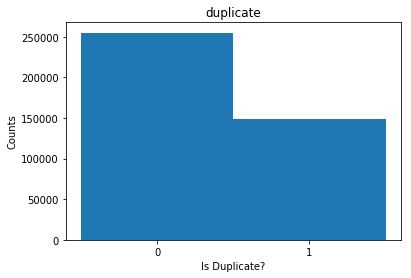

In [19]:
fig = plt.figure()
#ax = fig.add_subplot(111)
ax = df.hist('duplicate',bins=2, grid=False)
ax[0][0].set_xlabel("Is Duplicate?")
ax[0][0].set_ylabel("Counts")
N_zero = df['duplicate'].shape[0]-df['duplicate'].sum()
N_one = df['duplicate'].sum()
print("Classes: ",N_zero,N_one,N_one/N_zero)
ax[0][0]
plt.xticks([0.25,0.75],['0','1'])

In [20]:
# save the class weights to a dictionary
class_weight_map = {0:N_zero,1:N_one}

Let's take a look at basic sentence properties:

In [21]:
add_token_col(df,'q1')
add_token_col(df,'q2')

/home/jbryslaw/anaconda3/envs/mednet/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [22]:
q1_uniq_tokens = get_uniq(df,'q1_tokens')
q2_uniq_tokens = get_uniq(df,'q2_tokens')
q1q2_inner = q1_uniq_tokens.intersection(q2_uniq_tokens)

In [23]:
q1_uniq_tokens = set_to_list(q1_uniq_tokens)
q2_uniq_tokens = set_to_list(q2_uniq_tokens)
q1q2_inner = list(q1q2_inner)

In [24]:
sum_vocab = [len(q1_uniq_tokens),len(q2_uniq_tokens),len(q1q2_inner)]
vocab_title = ['q1','q2','q1&&q2']

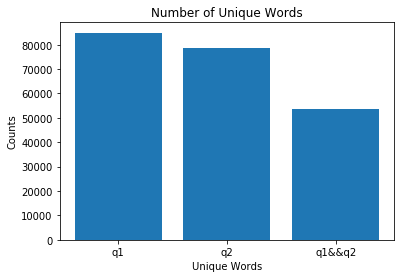

In [25]:
plot_list(sum_vocab,vocab_title,xtitle="Unique Words",title="Number of Unique Words")

We will form sentence embeddings as part of the EDA, because it will allow us to visualize important words and structures in the text.

### Validation Set
Since the test set is unlabeled, we will create a validation set to test any models. The training set is split into a validation set, with a random 80,20 split. We will do that here, before proceeding to the rest of the EDA. This way any models or embedding transformations performed during the EDA do not contaminate the validation set.

In [26]:
X_train, X_val, y_train, y_val = train_test_split(df[['q1','q2']],\
                    df[['duplicate']],test_size = 0.2, random_state=SEED)

#### Bag of Words:
To visualize the distributions of matched and unmatched questions, BOW and TFIDF vectors are generated. These TF-IDF vectors will also be used for the final end-to-end classification.

In [27]:
#BOW
bow_model = embObj(X_train)
allq_BOWemb,BOW_cv = bow_model.bow()
train_BOWembq1, train_BOWembq2  = bow_model.bow_trnsfrm(X_train)
val_BOWembq1, val_BOWembq2  = bow_model.bow_trnsfrm(X_val)

In [28]:
#TFIDF w Ngrams
tfidf_model = embObj(X_train)
allq_TFemb,TFIDF_cv = tfidf_model.TFIDF()
train_tfembq1, train_tfembq2 = tfidf_model.tfidf_trnsfrm(X_train)
val_tfembq1, val_tfembq2 = tfidf_model.tfidf_trnsfrm(X_val)

Let's take a first look at the embeddings. To get a quick look at class separation, we can take the vector sum of each question embedding and plot its class label.

In [29]:
trainBOW_vsum = train_BOWembq1+train_BOWembq2
valBOW_vsum = val_BOWembq1+val_BOWembq2
train_tf_vsum = train_tfembq1+train_tfembq2
val_tf_vsum = val_tfembq1+val_tfembq2

We can get a quick idea of the class separation, buy plotting after performing a 2D PCA.

#### BOW embedding distributions:
Duplicates shown in blue, Non-duplicates shown in Orange.

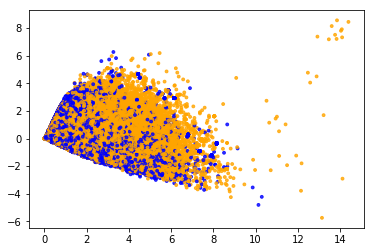

In [30]:
plot_PCA_emb(trainBOW_vsum,y_train)

#### TFIDF embedding distributions:
Duplicates shown in blue, Non-duplicates shown in Orange.

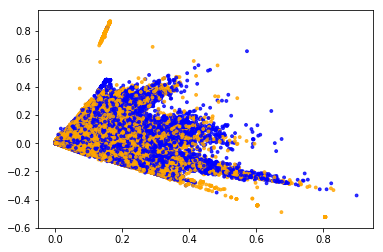

In [31]:
plot_PCA_emb(train_tf_vsum,y_train)

Visually, the simple bag of words model appears more separated than the TF-IDF model. This indicates the importance of what normaly are considered stop words, in understanding what is being asked in questions.

### Baseline Prediction
In order to have a baseline for the more complex BDT model, let's perform a simple logistic regression binary classification. As features, the vector sum of the TFIDF embeddings of question 1 and question 2 for every question pair is used. The model will be fit on the training set, and predicted using the validation set. This naive model will give a lower bound on the performance we should expect from more complicated models.

/home/jbryslaw/anaconda3/envs/mednet/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jbryslaw/anaconda3/envs/mednet/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Recall: 0.6561703554661301 
 Precision: 0.761124941652404 
 ACC: 0.7972494991219174 
 [[0.65617036 0.34382964]
 [0.12032211 0.87967789]]


array([[0.97649989, 0.02350011],
       [0.58835038, 0.41164962],
       [0.70530671, 0.29469329],
       ...,
       [0.88963763, 0.11036237],
       [0.73331993, 0.26668007],
       [0.94355223, 0.05644777]])

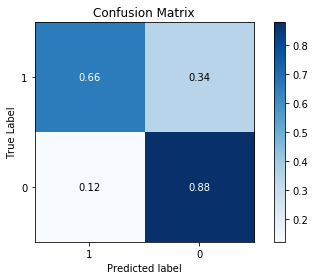

In [32]:
fit_logr(train_tf_vsum,y_train,val_tf_vsum,y_val,thresh=0.5)

The baseline prediction with logistic regression on the vector sum of the question TFIDF embeddings obtains an accuracy of 79.7%, recall of 65.6% and precision of 76.1%.

### TOPIC MODELING

The importance of different components of the TFIDF embedding will vary for questions pairs occupying different topics. In order to capture this information, we will use Latent Dirichlet Allocation (LDA) topic modeling. 

LDA is sensitive to noise, so the data is first cleaned using stop words and regex rules defined in the cleaner class above.

In [33]:
lda_cleaner = cleaner()
X_train = lda_cleaner.regex(X_train,'q1')
X_train = lda_cleaner.regex(X_train,'q2')
X_val = lda_cleaner.regex(X_val,'q1')
X_val = lda_cleaner.regex(X_val,'q2')

In [34]:
# Construct and lda model class
#X_lda_train = X_train.iloc[:100000,:]
lda_model = lda_emb(X_train)
lda_model.stop_words = lda_cleaner.stop_words

LDA requires the number of topics to be predefined. In order to obtain the optimum number of topics, LDA models were created for the following number of topics: (5,10,25,50,100,250,500). 100 topics was selected since it resulted in the best u_mass coherence score. This iterative selection of topic number is done in the line below, but is commented out, since it takes several hours to complete.

In [35]:
#%time lda_model.gen_model_distro() # [5,10,25,50,100,250,500]
# print(lda_model.cohere_distro) 
# plot_scatter_list(lda_model.cohere_distro,lda_model.Ntopic_distro)

Fit the final LDA model, with the selected number of topics:

In [36]:
%time lda_model.get_single_model(10)

CPU times: user 11min 19s, sys: 37.3 ms, total: 11min 19s
Wall time: 11min 20s


In [37]:
#lda_model.read_model_distro()

In [38]:
#lda_model.showTopics(100)
#[obj[0] for obj in lda_model.top_words]

After a topic model is created, topics can be added to each question as a feature.

In [39]:
%%time
#select topic model
topicModel = lda_model.single_model

# add topic back to old docs
trainq1_emb = lda_emb(X_train.loc[:,'q1'])
trainq2_emb = lda_emb(X_train.loc[:,'q2'])
trainq1_emb.stop_words = lda_cleaner.stop_words
trainq1_emb.stop_words = lda_cleaner.stop_words
trainq1_emb.genTFIDF(singlecol=True)
trainq2_emb.genTFIDF(singlecol=True)

#predict topic for new docs
valq1_emb = lda_emb(X_val.loc[:,'q1'])
valq2_emb = lda_emb(X_val.loc[:,'q2'])
valq1_emb.stop_words = lda_cleaner.stop_words
valq1_emb.stop_words = lda_cleaner.stop_words
valq1_emb.genTFIDF(singlecol=True)
valq2_emb.genTFIDF(singlecol=True)

CPU times: user 11 s, sys: 3.97 ms, total: 11 s
Wall time: 11 s


In [40]:
X_val.shape

(80858, 2)

In [41]:
%%time
# get the predictic topic for each question
add_token_col(X_train,'q1')
add_token_col(X_train,'q2')
add_topic_col(X_train,'q1_tokens',trainq1_emb,topicModel)
add_topic_col(X_train,'q2_tokens',trainq1_emb,topicModel)
add_token_col(X_val,'q1')
add_token_col(X_val,'q2')
add_topic_col(X_val,'q1_tokens',valq1_emb,topicModel)
add_topic_col(X_val,'q2_tokens',valq1_emb,topicModel)

CPU times: user 2min 43s, sys: 108 ms, total: 2min 43s
Wall time: 2min 43s


In [42]:
%%time
q1_topics = X_train.loc[:,'q1_tokens_topic'].values
q2_topics = X_train.loc[:,'q2_tokens_topic'].values
val_q1_topics = X_val.loc[:,'q1_tokens_topic'].values
val_q2_topics = X_val.loc[:,'q2_tokens_topic'].values

CPU times: user 344 µs, sys: 0 ns, total: 344 µs
Wall time: 347 µs


In [43]:
%%time
q1_topics = sparse.csr_matrix(q1_topics)
q2_topics = sparse.csr_matrix(q2_topics)
val_q1_topics = sparse.csr_matrix(val_q1_topics)
val_q2_topics = sparse.csr_matrix(val_q2_topics)

CPU times: user 15 ms, sys: 0 ns, total: 15 ms
Wall time: 14.5 ms


In [44]:
%time q1_topics = q1_topics.T
q2_topics = q2_topics.T
val_q1_topics = val_q1_topics.T
val_q2_topics = val_q2_topics.T

CPU times: user 64 µs, sys: 0 ns, total: 64 µs
Wall time: 66.3 µs


### Named Entity Recognition

For certain question topic groups, it is important that proper names match between questions. Ideally Named Entity Recognition (NER) would be performed on each question, then the level of matching between NER objects would be used as a feature. Before performing the full NER matching, lets perform consine similarity on raw BOW as a proxy for strict NER matching.

In [45]:
%%time
train_cs = []
for i in range(train_BOWembq1.shape[0]):
    train_cs.append(cosine_similarity(train_BOWembq1[i], train_BOWembq2[i])[0][0])
# X_train['cs']=pd.DataFrame(train_cs)
# X_train.fillna(0,inplace=True)
val_cs = []
for i in range(val_BOWembq1.shape[0]):
    val_cs.append(cosine_similarity(val_BOWembq1[i], val_BOWembq2[i])[0][0])
# X_val['cs']=pd.DataFrame(val_cs)
# X_val.fillna(0,inplace=True)

CPU times: user 4min 20s, sys: 108 ms, total: 4min 20s
Wall time: 4min 20s


In [46]:
%%time
train_cs = sparse.csr_matrix(train_cs)
val_cs = sparse.csr_matrix(val_cs)
train_cs = train_cs.T
val_cs = val_cs.T

CPU times: user 39.5 ms, sys: 0 ns, total: 39.5 ms
Wall time: 38.7 ms


### Final Model
The final model, will be a boosted decision tree which will combine features from the end-to-end classification, LDA topic modeling and proper name matching.

In [47]:
X_train_features = sparse_hstack((train_tfembq1+train_tfembq2,q1_topics,q2_topics,train_cs))
X_val_features = sparse_hstack((val_tfembq1+val_tfembq2,val_q1_topics,val_q2_topics,val_cs))

In [48]:
%%time
xgb_fit = xgb.XGBClassifier(objective='binary:logistic', max_depth=30, n_estimators=5000,\
                            subsample=0.7,colsample_bytree=0.21,colsample_bylevel=0.21,\
                            colsample_bynode=0.5,\
                            eta=0.1, learning_rate=0.08,nthread=8)
# use the validation set to do early stopping
evaldata = [(X_train_features, y_train),(X_val_features, y_val)]
xgb_fit.fit(X_train_features, y_train,\
           eval_metric="auc", early_stopping_rounds=20,\
           eval_set=evaldata,verbose=False)

/home/jbryslaw/anaconda3/envs/mednet/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jbryslaw/anaconda3/envs/mednet/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 7h 49min 57s, sys: 7min, total: 7h 56min 57s
Wall time: 1h 8s


Let's take a look at the training performance:

In [49]:
y_pred_train = xgb_fit.predict(X_train_features)

Recall: 0.8304379494821797 
 Precision: 0.876716929767187 
 ACC: 0.8942549987787118


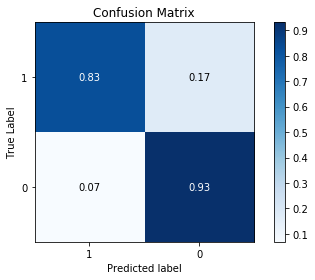

In [50]:
cm, R, P, ACC = get_cm(y_train,y_pred_train)
ncm = norm_cm(cm)
plot_cm(ncm)
print("Recall:",R,"\n","Precision:",P,"\n","ACC:",ACC)

In [51]:
y_pred = xgb_fit.predict(X_val_features)

Let's look at the performance on the validation set:

Recall: 0.7357813547954393 
 Precision: 0.7556741863268469 
 ACC: 0.8148235177718964


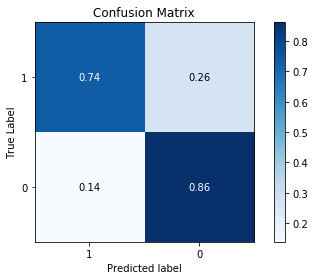

In [52]:
cm, R, P, ACC = get_cm(y_val,y_pred)
ncm = norm_cm(cm)
plot_cm(ncm)
print("Recall:",R,"\n","Precision:",P,"\n","ACC:",ACC)

The final model obtains an accuracy of 81.5%, a precision of 75.6% and a recall of 73.6%. There is a bit of a performance gap between the train metrics and the validation performance. This could be improved by increasing the regularization in the model

### Running on test set:
Now we can use the final model to make predictions on the unlabeled test set:

In [53]:
df_test = pd.read_csv("test.csv")
# drop na rows
df_test = df_test.fillna("")

In [54]:
#make column names a bit shorter
df_test.columns = ['test_id','q1','q2']
X_test = df_test[['q1','q2']]

Perform the embedding transformations as above:

In [55]:
test_BOWembq1, test_BOWembq2  = bow_model.bow_trnsfrm(X_test)
test_tfembq1, test_tfembq2 = tfidf_model.tfidf_trnsfrm(X_test)
test_tf_vsum = test_tfembq1+test_tfembq2

In [56]:
X_test = lda_cleaner.regex(X_test,'q1')
X_test = lda_cleaner.regex(X_test,'q2')

/home/jbryslaw/anaconda3/envs/mednet/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jbryslaw/anaconda3/envs/mednet/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jbryslaw/anaconda3/envs/mednet/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [57]:
testq1_emb = lda_emb(X_test.loc[:,'q1'],preset_dict=lda_model.dictionary)
testq2_emb = lda_emb(X_test.loc[:,'q2'],preset_dict=lda_model.dictionary)

In [58]:
testq1_emb.stop_words = lda_cleaner.stop_words
testq1_emb.stop_words = lda_cleaner.stop_words
testq1_emb.genTFIDF(singlecol=True)
testq2_emb.genTFIDF(singlecol=True)
add_token_col(X_test,'q1')
add_token_col(X_test,'q2')

In [59]:
add_topic_col(X_test,'q1_tokens',testq1_emb,topicModel)
add_topic_col(X_test,'q2_tokens',testq1_emb,topicModel)
test_q1_topics = X_test.loc[:,'q1_tokens_topic'].values
test_q2_topics = X_test.loc[:,'q2_tokens_topic'].values
test_q1_topics = sparse.csr_matrix(test_q1_topics)
test_q2_topics = sparse.csr_matrix(test_q2_topics)

In [60]:
test_q1_topics = test_q1_topics.T
test_q2_topics = test_q2_topics.T

In [61]:
# CS
test_cs = []
for i in range(test_BOWembq1.shape[0]):
    test_cs.append(cosine_similarity(test_BOWembq1[i], test_BOWembq2[i])[0][0])
test_cs = sparse.csr_matrix(test_cs)
test_cs = test_cs.T

In [62]:
X_test_features = sparse_hstack((test_tfembq1+test_tfembq2,test_q1_topics,test_q2_topics,test_cs))

In [63]:
y_test_predictions = xgb_fit.predict(X_test_features)

In [64]:
y_test_predictions.shape[0]

2345796

In [65]:
test_ids = np.arange(0,y_test_predictions.shape[0])

In [66]:
out = np.vstack((test_ids,y_test_predictions)).T

In [67]:
# save to csv
np.savetxt('submission.csv',out, delimiter=',',fmt='%d')

The final log-loss on the test set reported by the challenge is 6.1, the final performance on the validation set obtained an accuracy of 81.5%, a precision of 75.6% and a recall of 73.6%. This could be improved, first by completing the NER model. The parameters of the final model should also be tuned using cross-validation, especially the regularization since there still appears to be a gap between performance in training and validation.